In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data2/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data2/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data2/names/Czech.txt', 'data2/names/German.txt', 'data2/names/Arabic.txt', 'data2/names/Japanese.txt', 'data2/names/Chinese.txt', 'data2/names/Vietnamese.txt', 'data2/names/Russian.txt', 'data2/names/French.txt', 'data2/names/Irish.txt', 'data2/names/English.txt', 'data2/names/Spanish.txt', 'data2/names/Greek.txt', 'data2/names/Italian.txt', 'data2/names/Portuguese.txt', 'data2/names/Scottish.txt', 'data2/names/Dutch.txt', 'data2/names/Korean.txt', 'data2/names/Polish.txt']
Slusarski


In [2]:
import torch
import torch.nn as nn

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

import random
random.seed(333)
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


In [3]:
# import torch.nn.functional as F
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # [1,input_size+hidden_size]
        combined = torch.cat((input, hidden), 1)
        # [1,hidden_size]
        hidden = torch.relu(self.i2h(combined))
        # [1,18]
        output = self.h2o(hidden)
        # [1,18]
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [4]:
torch.manual_seed(222)
rnn = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
import torch.optim as optim
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [5]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.4459 Karkampasis / Greek ✓
10000 10% (0m 12s) 3.1063 Mcintyre / Irish ✗ (Scottish)
15000 15% (0m 18s) 2.2968 Gouveia / Polish ✗ (Portuguese)
20000 20% (0m 25s) 2.1680 Albrecht / Dutch ✗ (German)
25000 25% (0m 32s) 1.6996 Mateus / Greek ✗ (Portuguese)
30000 30% (0m 38s) 1.9027 Babanoff / Japanese ✗ (Russian)
35000 35% (0m 44s) 0.5981 Bengochea / Spanish ✓
40000 40% (0m 51s) 2.5499 D'cruze / French ✗ (Portuguese)
45000 45% (0m 58s) 1.0663 Chai / Chinese ✓
50000 50% (1m 4s) 1.1546 Attia / Arabic ✓
55000 55% (1m 11s) 0.8016 Marquez / Portuguese ✗ (Spanish)
60000 60% (1m 17s) 0.9673 Robert / Dutch ✓
65000 65% (1m 23s) 1.6935 Vogt / French ✗ (German)
70000 70% (1m 30s) 0.0171 Ponkratov / Russian ✓
75000 75% (1m 36s) 1.3032 Hierro / Portuguese ✗ (Spanish)
80000 80% (1m 43s) 0.5205 Roggeveen / Dutch ✓
85000 85% (1m 49s) 0.0967 Mcmillan / Scottish ✓
90000 90% (1m 56s) 0.0057 Ashikaga / Japanese ✓
95000 95% (2m 2s) 2.9952 Wood / Korean ✗ (Czech)
100000 100% (2m 8s) 0.0766 Meeuw

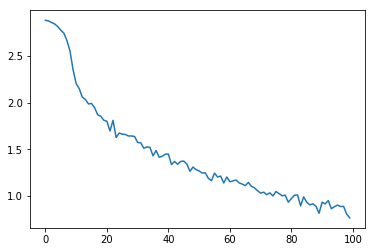

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)